<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Mikhail Tribunskiy, @MITribunskiy
    
## <center> Tutorial
### <center> "CatBoost overview"

# Introduction
CatBoost is an open-source gradient boosting on decision trees library developed by Yandex. 
CatBoost can be used for solving problems, such as: 
- classification (binary, multi-class)
- regression
- ranking

These tasks differ by their objective function, that we are trying to minimize during gradient descend. Moreover, Catboost have pre-build metrics to measure the accuracy of the model.

On official CatBoost [website](https://catboost.ai/#benchmark) you can find the comparison of Catboost with major benchmarks.

Catboost introduces the followign algorithmic advances:

**1. Categorical features support:**

For data with categorical features the accuracy of CatBoost would be better compared to other algorithms. You do not need to preprocess categorical features (like one-hot encoding), just specify some hyperparameters (will be shown below, we will also use **HP** for hyperparameters).

**2. Better overfitting handling:**

CatBoost uses the implementation of ordered boosting, an alternative to the classic boosting algorithm.  
For example, the gradient boosting is quickly overfitted on small datasets. In Catboost there is a special modification for such cases, so on small datasets where other algorithms had a problem of overfitting you won’t observe the same problem with Catboost.

**3. Fast and easy-to-use GPU-training:**

The versions of CatBoost available from pip install (*pip install catboost*) and conda install (*conda install catboost*) have GPU support out-of-the-box. You just need to specify that you want to train your model on GPU in the corresponding HP (will be shown below).

**4. Other useful features:**

Missing value support (***nan_mode*** HP), great visualization.

Ok, let's get started:

In [1]:
# to get no error executing this kernel, it is neccessary to update catboost to version 0.14.2 +
!pip3 install catboost scikit-learn ipywidgets seaborn shap


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import catboost
print(catboost.__version__)



1.2.8


# Classification task

We import model for solving classification tasks:

In [3]:
from catboost import CatBoostClassifier

Let's use example datasets. 

In [4]:
from catboost import datasets

train_df, test_df = datasets.amazon() # nice datasets with categorical features only :D
train_df.shape, test_df.shape

((32769, 10), (58921, 10))

In [5]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


train_df has the same amount of columns as test_df, although it contains label(target) column. Does our test_df dataset contain target values, too?

In [6]:
test_df.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


Unfortunately, no. However, you can check your model predictions by submitting them [here](https://www.kaggle.com/c/amazon-employee-access-challenge/overview). That's an old Kaggle competition but you can still make submissions to test yourself. We will also use the same metric to evaluate our model: [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

Although datasets contain numerical values, these features are actually codes for different properties of an employee: manager id, company role code and other. Thus, these datasets contain categorical features.

Let's separate features and label values:

In [7]:
y = train_df['ACTION']
X = train_df.drop(columns='ACTION') # or X = train_df.drop('ACTION', axis=1)

In [8]:
X_test = test_df.drop(columns='id')

To make further results reproducible we will use fixed random seed.

In [9]:
SEED = 1

To estimate the result of the training let's split train data on train and validation parts.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=SEED)

What time is it? Training time!

In [11]:
%%time

params = {'loss_function':'Logloss', # objective function
          'eval_metric':'AUC', # metric
          'verbose': 200, # output to stdout info about training process every 200 iterations
          'random_seed': SEED
         }
cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(X_train, y_train, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_valid, y_valid), # data to validate on
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.069882
0:	test: 0.5400959	best: 0.5400959 (0)	total: 64.1ms	remaining: 1m 3s
200:	test: 0.8020842	best: 0.8020842 (200)	total: 725ms	remaining: 2.88s
400:	test: 0.8237941	best: 0.8237941 (400)	total: 1.26s	remaining: 1.88s
600:	test: 0.8328464	best: 0.8330283 (598)	total: 1.77s	remaining: 1.17s
800:	test: 0.8366271	best: 0.8370599 (785)	total: 2.29s	remaining: 568ms
999:	test: 0.8417823	best: 0.8417823 (999)	total: 2.79s	remaining: 0us

bestTest = 0.8417823185
bestIteration = 999

CPU times: user 15.3 s, sys: 2.44 s, total: 17.7 s
Wall time: 2.88 s


Only 0.829? That's not even top 50%. Though to be honest, our model could show better results if we allowed it to train for more iterations (by default, it's 1000). Still, how else can we improve our results? First of all, we should finally specify, what features are categorical. In the above model CatBoost treated categorical features as numerical ones. Thus, the categories were ranked.

Let's fix that problem by specifying a HP ***cat_features=[i1, i2, ... , in]*** (list of integers):

In [12]:
cat_features = list(range(X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


What we did here is that we created a list of feature (column) numbers which we want CatBoost to treat as the categorical ones. And in our dataset all features are categorical.

If not all features are categorical but we have their names, we can specify ***cat_features*** like this:

In [13]:
cat_features_names = X.columns # here we specify names of categorical features
cat_features = [X.columns.get_loc(col) for col in cat_features_names]
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Or if we know how to distinguish a categorical feature from the numerical one:

In [14]:
condition = True # here we specify what condition should be satisfied only by the names of categorical features
cat_features_names = [col for col in X.columns if condition]
cat_features = [X.columns.get_loc(col) for col in cat_features_names]
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [15]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'verbose': 200,
          'random_seed': SEED
         }
cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),
          use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.069882
0:	test: 0.5637606	best: 0.5637606 (0)	total: 21.7ms	remaining: 21.7s
200:	test: 0.8959353	best: 0.8959406 (199)	total: 2.66s	remaining: 10.6s
400:	test: 0.8991769	best: 0.8992453 (394)	total: 6.03s	remaining: 9.01s
600:	test: 0.8993643	best: 0.8997443 (545)	total: 9.09s	remaining: 6.03s
800:	test: 0.8960170	best: 0.8997443 (545)	total: 12s	remaining: 2.97s
999:	test: 0.8954456	best: 0.8997443 (545)	total: 14.8s	remaining: 0us

bestTest = 0.8997443413
bestIteration = 545

Shrink model to first 546 iterations.
CPU times: user 1min 11s, sys: 9.26 s, total: 1min 20s
Wall time: 15.2 s


Ah, much better. Moreover, we obtained our best result much faster (iteration 412), though overall training took much more time. We can handle this problem by specifying HP ***early_stopping_rounds=N***, meaning that if the metric result do not improve for N rounds, model should stop training:

In [16]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': SEED
         }
cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(X_train, y_train, 
          eval_set=(X_valid, y_valid), 
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.069882
0:	test: 0.5637606	best: 0.5637606 (0)	total: 13.5ms	remaining: 13.5s
200:	test: 0.8959353	best: 0.8959406 (199)	total: 2.31s	remaining: 9.2s
400:	test: 0.8991769	best: 0.8992453 (394)	total: 5.25s	remaining: 7.84s
600:	test: 0.8993643	best: 0.8997443 (545)	total: 7.79s	remaining: 5.17s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8997443413
bestIteration = 545

Shrink model to first 546 iterations.
CPU times: user 53.2 s, sys: 6.4 s, total: 59.6 s
Wall time: 9.8 s


By default CatBoost uses CPU to make calculations. What will change if we make it conduct the calculations on GPU? To do so, we need to specify HP ***task_type='GPU'***. Let's train our model on GPU (without overfitting HP ***early_stopping_rounds***):

In [17]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'task_type': 'GPU',
          'verbose': 200,
          'random_seed': SEED
         }
cbc_3 = CatBoostClassifier(**params)
cbc_3.fit(X_train, y_train,
          eval_set=(X_valid, y_valid), 
          use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: catboost/libs/train_lib/trainer_env.cpp:9: Environment for task type [GPU] not found

Well, the results didn't change much. Still, they are not the same, so it worth trying. Moreover, some HP can be set only if the model trains on GPU.  
These are: 
- tree growing policy (***grow_policy***)
- the minimum number of training samples in a leaf (***min_data_in_leaf***)
- the maximum number of leafs in the resulting tree (***max_leaves***)

etc.

These HP may significantly help in model tuning.

In some datasets training on GPU takes much less time. Training on GPU can be sped up further by specifying HP ***border_count=N***, where N defines the number of splits considered for each feature. CatBoost documentation suggests setting the value of this parameter to **32** if training is performed on GPU. In many cases, this does not affect the quality of the model but significantly speeds up the training. Let's check if that is also our case:

In [18]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'task_type': 'GPU',
          'border_count': 32,
          'verbose': 200,
          'random_seed': SEED
         }
cbc_4 = CatBoostClassifier(**params)
cbc_4.fit(X_train, y_train, 
          eval_set=(X_valid, y_valid), 
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: catboost/libs/train_lib/trainer_env.cpp:9: Environment for task type [GPU] not found

Indeed, it doesn't affect much the model quality. However, the training process completed almost twice faster. Nice!

In some cases we may suspect that some features give us misleading information. To experiment with this idea we can either create numerous of slices of our data, or we can just specify in the model HP ***ignored_features=[i1, i2, ... , in]***, list of column numbers we want to ignore.

First, let's create columns with data which will puzzle our model:

In [19]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [20]:
np.random.seed(SEED)
noise_cols = [f'noise_{i}' for i in range(5)]
for col in noise_cols:
    X_train[col] = y_train * np.random.rand(X_train.shape[0])
    X_valid[col] = np.random.rand(X_valid.shape[0])

In [21]:
X_train.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,noise_0,noise_1,noise_2,noise_3,noise_4
16773,27798,1350,117961,118052,122938,117905,117906,290919,117908,0.417022,0.097850,0.665600,0.979025,0.491624
23491,80701,4571,117961,118225,119924,118685,279443,308574,118687,0.720324,0.855900,0.311763,0.929346,0.391708
32731,34039,5113,117961,118300,119890,119433,133686,118424,119435,0.000114,0.287838,0.896624,0.704050,0.606467
7855,42085,4733,118290,118291,120126,118980,166203,118295,118982,0.302333,0.264320,0.482195,0.028493,0.182570
16475,16358,6046,117961,118446,120317,307024,306404,118331,118332,0.146756,0.022876,0.009307,0.726750,0.623357


In [22]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'verbose': 200,
          'random_seed': SEED
         }
cbc_5 = CatBoostClassifier(**params)
cbc_5.fit(X_train, y_train, 
          eval_set=(X_valid, y_valid), 
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.069882
0:	test: 0.4990944	best: 0.4990944 (0)	total: 11ms	remaining: 11s
200:	test: 0.5823041	best: 0.5894476 (7)	total: 2s	remaining: 7.94s
400:	test: 0.5823041	best: 0.5894476 (7)	total: 3.99s	remaining: 5.97s
600:	test: 0.5823041	best: 0.5894476 (7)	total: 6.14s	remaining: 4.08s
800:	test: 0.5823041	best: 0.5894476 (7)	total: 7.95s	remaining: 1.97s
999:	test: 0.5823041	best: 0.5894476 (7)	total: 9.49s	remaining: 0us

bestTest = 0.5894475816
bestIteration = 7

Shrink model to first 8 iterations.
CPU times: user 51.1 s, sys: 6.19 s, total: 57.3 s
Wall time: 9.68 s


Wow, didn't expect it to be that low. Let's specify columns which we want to ignore:

In [23]:
ignored_features = list(range(X_train.shape[1] - 5, X_train.shape[1]))
print(ignored_features)

[9, 10, 11, 12, 13]


In [24]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'ignored_features': ignored_features,
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': SEED
         }
cbc_6 = CatBoostClassifier(**params)
cbc_6.fit(X_train, y_train, 
          eval_set=(X_valid, y_valid), 
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.069882
0:	test: 0.5637606	best: 0.5637606 (0)	total: 25.5ms	remaining: 25.5s
200:	test: 0.8959353	best: 0.8959406 (199)	total: 2.27s	remaining: 9.02s
400:	test: 0.8991769	best: 0.8992453 (394)	total: 4.74s	remaining: 7.09s
600:	test: 0.8993643	best: 0.8997443 (545)	total: 7.21s	remaining: 4.78s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8997443413
bestIteration = 545

Shrink model to first 546 iterations.
CPU times: user 53.9 s, sys: 5.78 s, total: 59.7 s
Wall time: 9.14 s


Problem fixed. Good. We obtained the same results as in cbc_2 model, where there were no misleading features. Now let's get rid of them:

In [25]:
X_train = X_train.drop(columns=noise_cols)
X_valid = X_valid.drop(columns=noise_cols)

In [26]:
X_train.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
16773,27798,1350,117961,118052,122938,117905,117906,290919,117908
23491,80701,4571,117961,118225,119924,118685,279443,308574,118687
32731,34039,5113,117961,118300,119890,119433,133686,118424,119435
7855,42085,4733,118290,118291,120126,118980,166203,118295,118982
16475,16358,6046,117961,118446,120317,307024,306404,118331,118332


CatBoostClassifier.fit() method can also accept pool object as a train data:

In [27]:
from catboost import Pool

train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )

valid_data = Pool(data=X_valid,
                  label=y_valid,
                  cat_features=cat_features
                 )

In [28]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
#           'cat_features': cat_features, # we don't need to specify this parameter as 
#                                           pool object contains info about categorical features
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': SEED
         }

cbc_7 = CatBoostClassifier(**params)
cbc_7.fit(train_data, # instead of X_train, y_train
          eval_set=valid_data, # instead of (X_valid, y_valid)
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.069882
0:	test: 0.5637606	best: 0.5637606 (0)	total: 26.9ms	remaining: 26.9s
200:	test: 0.8959353	best: 0.8959406 (199)	total: 2.31s	remaining: 9.2s
400:	test: 0.8991769	best: 0.8992453 (394)	total: 4.75s	remaining: 7.09s
600:	test: 0.8993643	best: 0.8997443 (545)	total: 7.18s	remaining: 4.77s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8997443413
bestIteration = 545

Shrink model to first 546 iterations.
CPU times: user 54.3 s, sys: 5.45 s, total: 59.7 s
Wall time: 8.97 s


As we can see, we obtained the same results as for cbc_2. Then why should we bother creating Pool objects? Pool object has some nice methods. For example, some parts of our data may be outdated, inaccurate. With ***Pool.set_weight()*** we can specify weights to instances (rows) of our data. Or we can divide data on groups using ***Pool.set_group_id()*** and play with different weights for different groups using ***Pool.set_group_weight()***.  We may have a baseline calculated. Then we will be able to provide initial formula values for all input objects using ***Pool.set_baseline()***. Thus, training will start from these values for all input objects instead of starting from zero.

Finally, Pool object is also a nice way to contain bounded parts of data.

For more thorough cross-validation procedure we can use **cv** from catboost:

In [29]:
from catboost import cv

In [30]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': SEED
         }

all_train_data = Pool(data=X,
                      label=y,
                      cat_features=cat_features
                     )

scores = cv(pool=all_train_data,
            params=params, 
            fold_count=4,
            seed=SEED, 
            shuffle=True,
            stratified=True, # if True the folds are made by preserving the percentage of samples for each class
            plot=True
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]
0:	test: 0.5000000	best: 0.5000000 (0)	total: 9.95ms	remaining: 9.94s
200:	test: 0.8949684	best: 0.8950317 (197)	total: 2.76s	remaining: 11s
400:	test: 0.9000696	best: 0.9000903 (398)	total: 5.89s	remaining: 8.8s
600:	test: 0.9028457	best: 0.9028457 (600)	total: 8.9s	remaining: 5.91s
800:	test: 0.9040991	best: 0.9041981 (775)	total: 11.9s	remaining: 2.96s
999:	test: 0.9054401	best: 0.9054403 (998)	total: 14.9s	remaining: 0us

bestTest = 0.9054403241
bestIteration = 998

Training on fold [1/4]
0:	test: 0.5000000	best: 0.5000000 (0)	total: 6.33ms	remaining: 6.33s
200:	test: 0.8810243	best: 0.8812654 (169)	total: 4.77s	remaining: 19s
400:	test: 0.8835452	best: 0.8835452 (400)	total: 8.63s	remaining: 12.9s
600:	test: 0.8845225	best: 0.8846111 (596)	total: 12.3s	remaining: 8.15s
800:	test: 0.8844285	best: 0.8848360 (755)	total: 17s	remaining: 4.22s
999:	test: 0.8833154	best: 0.8848360 (755)	total: 21.6s	remaining: 0us

bestTest = 0.88483604
bestIteration = 755

Traini

Now, what shall we do to to estimate feature importance?

First of all, let's check result of **.get_feature_importance()** method of the fitted model:

In [31]:
cbc_7.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RESOURCE,20.364070
1,ROLE_DEPTNAME,15.765438
2,MGR_ID,15.496170
3,ROLE_ROLLUP_2,11.992021
4,ROLE_FAMILY_DESC,9.967565
5,ROLE_TITLE,8.178585
6,ROLE_ROLLUP_1,6.211102
7,ROLE_FAMILY,6.064792
8,ROLE_CODE,5.960258


In [32]:
import pandas as pd

feature_importance_df = pd.DataFrame(cbc_7.get_feature_importance(prettified=True), columns=['feature', 'importance'])
feature_importance_df

,feature,importance
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN


Or in a more illustrative way:

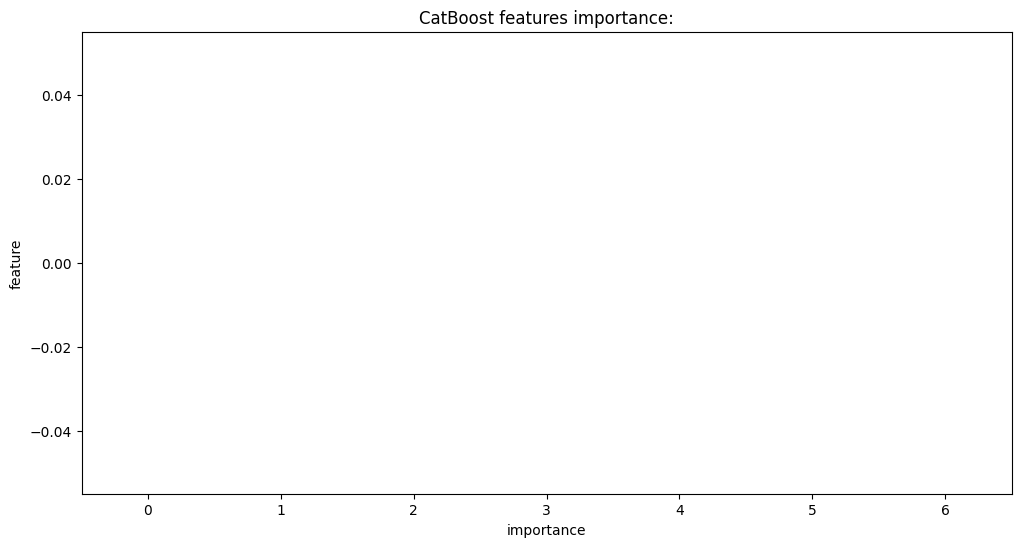

In [33]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=feature_importance_df);
plt.title('CatBoost features importance:');

Let's go deeper:

In [34]:
import shap
explainer = shap.TreeExplainer(cbc_7) # insert your model
shap_values = explainer.shap_values(train_data) # insert your train Pool object

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

That's an interactive plot. You can analyse your model by switching parameters for both abscissa and ordinate. Keep in mind that it's made from the slice of the data (first 100 instances).

Let us check summary plot:

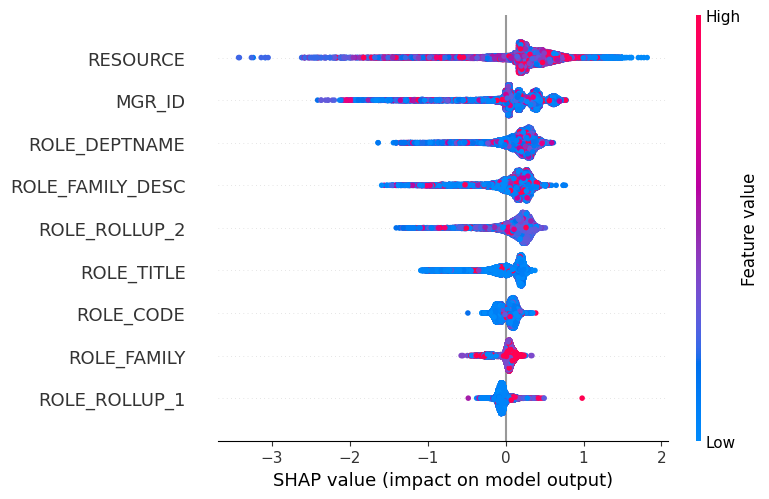

In [35]:
shap.summary_plot(shap_values, X_train)

Look like it matters who is your manager (MGR_ID) :D

On the above diagram every employee (instance/row in our dataset) is represented by one dot in each row. The x position of the dot is the impact of that feature on the model’s prediction, and the color of the dot represents the value of that feature for that exact employee. Dots that do not fit on the row pile up to show density. Here we can see that 'ROLE_ROLLUP_1' and 'ROLE_CODE' features have low impact on the model prediction, and for most of employees their impact is almost zero.

Finally, let us make a prediction:

In [36]:
%%time

from sklearn.model_selection import StratifiedKFold

n_fold = 4 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=SEED)

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': SEED
         }

test_data = Pool(data=X_test,
                 cat_features=cat_features)

scores = []
prediction = np.zeros(X_test.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    
    train_data = Pool(data=X_train, 
                      label=y_train,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid, 
                      label=y_valid,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    
    print(model.get_best_score())

    
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))

Learning rate set to 0.069882
0:	test: 0.5797111	best: 0.5797111 (0)	total: 15.2ms	remaining: 15.2s
200:	test: 0.8638646	best: 0.8638646 (200)	total: 2.55s	remaining: 10.2s
400:	test: 0.8678851	best: 0.8679522 (398)	total: 5.29s	remaining: 7.91s
600:	test: 0.8699053	best: 0.8703395 (566)	total: 8s	remaining: 5.31s
800:	test: 0.8731380	best: 0.8733745 (785)	total: 10.8s	remaining: 2.68s
999:	test: 0.8731273	best: 0.8741200 (924)	total: 13.5s	remaining: 0us

bestTest = 0.8741199656
bestIteration = 924

Shrink model to first 925 iterations.
{'learn': {'Logloss': 0.1040555732337259}, 'validation': {'Logloss': 0.14828298230178405, 'AUC': 0.8741199656305834}}
Learning rate set to 0.069883
0:	test: 0.5000000	best: 0.5000000 (0)	total: 6.06ms	remaining: 6.06s
200:	test: 0.8934693	best: 0.8934693 (200)	total: 2.85s	remaining: 11.3s
400:	test: 0.8977546	best: 0.8979621 (345)	total: 6.31s	remaining: 9.43s
600:	test: 0.8997586	best: 0.8997632 (596)	total: 9.67s	remaining: 6.42s
800:	test: 0.899467

In [37]:
import pandas as pd

sub = pd.read_csv('./sampleSubmission.csv')
sub['Action'] = prediction
sub_name = 'catboost_submission.csv'
sub.to_csv(sub_name, index=False)

print(f'Saving submission file as: {sub_name}')

Saving submission file as: catboost_submission.csv


Let us submit it [here](https://www.kaggle.com/c/amazon-employee-access-challenge/submit). 0.90741 private score! That's silver medal! Too bad it closed 6 years ago :D

### Some comments on Regularization tasks

CatBoost also has tools for solving regularization problem:

In [38]:
from catboost import CatBoostRegressor

Generally speaking, it differs from CatBoostClassifier only by the objective function (*Root Mean Square Error* (**RMSE**) for regression tasks by default) and by final predictions :D Training is done by the same method **.fit()** with the same tuning HP (more parameters [here](https://catboost.ai/docs/concepts/python-reference_parameters-list.html)).

If you are interested in other objectives and metrics, I would advice checking [Objectives and metrics](https://catboost.ai/docs/concepts/loss-functions.html) section in CatBoost documentation.

# Summary

To make a long story short, CatBoost provides useful tools for easy work with highly categorized data. It shows solid results training on unprocessed categorical features. Calculation on GPU is controlled by only 1 parameter. Moreover, CatBoost has a really comprehensive documentation.


# Resources

1. [CatBoost documentation](https://catboost.ai/docs/)
2. [CatBoost tutorials repository](https://github.com/catboost/tutorials)
3. [Introduction to gradient boosting on decision trees with Catboost](https://towardsdatascience.com/introduction-to-gradient-boosting-on-decision-trees-with-catboost-d511a9ccbd14)
4. [Working with categorical data: Catboost](https://medium.com/whats-your-data/working-with-categorical-data-catboost-8b5e11267a37)
5. [Interpretable Machine Learning with XGBoost](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)